In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9086
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #pole length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  F7UPK8AX_06_48_30
NN-MODEL FILENAME:  ./models/F7UPK8AX_06_48_30_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.725
LENGTH_ABS_MIN = 0.275

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 4
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  4


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
     # Mean values of pole length deviate from original value
    scaling_factor = 0.4 + (1.4 - 0.4) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    LENGTH_MAX = length_mean + 0.025
    LENGTH_MIN = length_mean - 0.025

    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN,     LENGTH_MAX,     LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    my_Q_TABLE = node_q_table[:,:,:,:, int(node_id*LO_GRAIN):int((node_id+1)*LO_GRAIN)]

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN*NO_OF_NODES   ])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN,LO_GRAIN*NO_OF_NODES).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 47543.75 MiB, increment: 43495.67 MiB
Quantization TIME:  0.39 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   13288
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 46
TOTAL SERIAL TIMESTEPS:   13288
TOTAL PARALLEL TIMESTEPS: 46


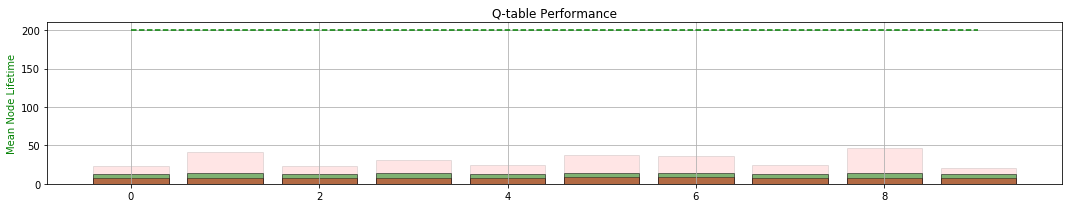

MEMORY COUNTER:  13288
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 661.186	LOSS : 596.502	LOSS : 594.262	LOSS : 582.051	LOSS : 571.825	LOSS : 579.919	LOSS : 563.356	LOSS : 560.309	LOSS : 563.911	LOSS : 540.347	LOSS : 531.706	LOSS : 530.012	LOSS : 539.439	LOSS : 526.039	LOSS : 521.265	LOSS : 514.657	LOSS : 509.780	LOSS : 507.921	LOSS : 502.039	LOSS : 497.275	
Validating... MEAN TIME:  107.685
LOSS : 491.261	LOSS : 500.498	LOSS : 502.499	LOSS : 507.724	LOSS : 478.406	LOSS : 511.513	LOSS : 487.396	LOSS : 472.139	LOSS : 501.422	LOSS : 488.257	LOSS : 471.713	LOSS : 504.170	LOSS : 477.630	LOSS : 488.952	LOSS : 473.375	LOSS : 479.947	LOSS : 486.946	LOSS : 489.230	LOSS : 479.272	LOSS : 479.875	
Validating... MEAN TIME:  125.355
LOSS : 463.721	LOSS : 478.642	LOSS : 460.757	LOSS : 483.494	LOSS : 481.432	LOSS : 450.747	LOSS : 468.806	LOSS : 462.455	LOSS : 473.966	LOSS : 465.456	LOSS : 457.346	LOSS : 470.137	LOSS : 454.185	LOSS : 468.541	LOSS : 473.456	LOSS : 475.614	LOSS : 4

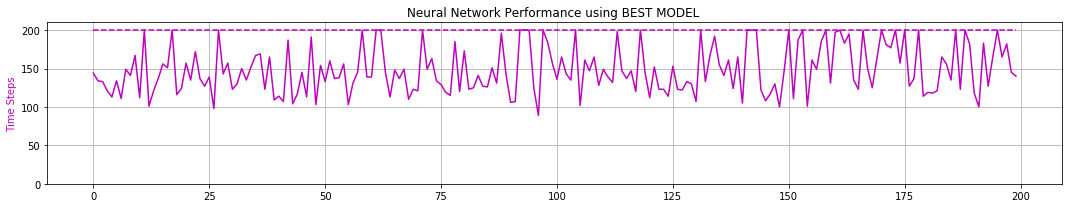

peak memory: 48495.43 MiB, increment: 43630.88 MiB
0 -max- [ 0.205  1.907  0.205  2.708  0.274]
0 -min- [-0.202 -1.774 -0.209 -2.755  0.225]

1 -max- [ 0.301  1.805  0.209  3.268  0.325]
1 -min- [-0.232 -2.673 -0.209 -2.754  0.275]

2 -max- [ 0.206  1.929  0.209  2.760  0.375]
2 -min- [-0.195 -1.780 -0.209 -2.833  0.325]

3 -max- [ 0.235  1.955  0.209  2.747  0.425]
3 -min- [-0.187 -1.711 -0.209 -2.888  0.375]

4 -max- [ 0.218  1.787  0.209  2.900  0.474]
4 -min- [-0.194 -1.971 -0.208 -2.734  0.426]

5 -max- [ 0.437  2.267  0.209  2.938  0.525]
5 -min- [-0.221 -1.962 -0.208 -2.945  0.476]

6 -max- [ 0.366  2.540  0.207  2.502  0.575]
6 -min- [-0.192 -1.598 -0.208 -2.900  0.525]

7 -max- [ 0.222  2.147  0.209  2.748  0.624]
7 -min- [-0.202 -1.806 -0.209 -2.965  0.576]

8 -max- [ 0.437  2.458  0.209  2.924  0.675]
8 -min- [-0.208 -1.921 -0.209 -2.914  0.625]

9 -max- [ 0.194  1.802  0.209  2.788  0.724]
9 -min- [-0.200 -1.792 -0.209 -2.746  0.675]

Quantization TIME:  0.39 minutes


ITER

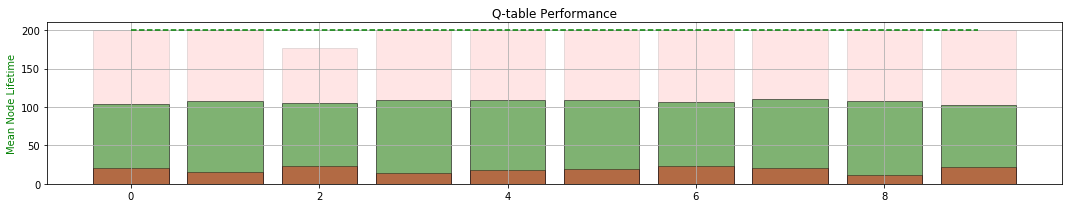

MEMORY COUNTER:  120275
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 331.958	LOSS : 319.284	LOSS : 298.367	LOSS : 274.391	LOSS : 277.485	LOSS : 259.665	LOSS : 234.288	LOSS : 234.231	LOSS : 216.692	LOSS : 201.939	LOSS : 211.295	LOSS : 204.969	LOSS : 198.590	LOSS : 187.940	LOSS : 176.158	LOSS : 183.887	LOSS : 179.354	LOSS : 178.030	LOSS : 184.381	LOSS : 179.576	
Validating... MEAN TIME:  132.51
LOSS : 180.102	LOSS : 163.228	LOSS : 167.525	LOSS : 176.761	LOSS : 172.391	LOSS : 162.432	LOSS : 164.014	LOSS : 160.269	LOSS : 151.142	LOSS : 165.086	LOSS : 165.768	LOSS : 170.113	LOSS : 153.474	LOSS : 163.019	LOSS : 175.206	LOSS : 156.026	LOSS : 155.036	LOSS : 140.657	LOSS : 155.368	LOSS : 160.903	
Validating... MEAN TIME:  146.24
LOSS : 161.700	LOSS : 157.803	LOSS : 167.736	LOSS : 163.964	LOSS : 167.069	LOSS : 150.321	LOSS : 158.428	LOSS : 159.595	LOSS : 162.615	LOSS : 162.618	LOSS : 145.632	LOSS : 157.634	LOSS : 159.746	LOSS : 164.438	LOSS : 156.902	LOSS : 167.197	LOSS : 15

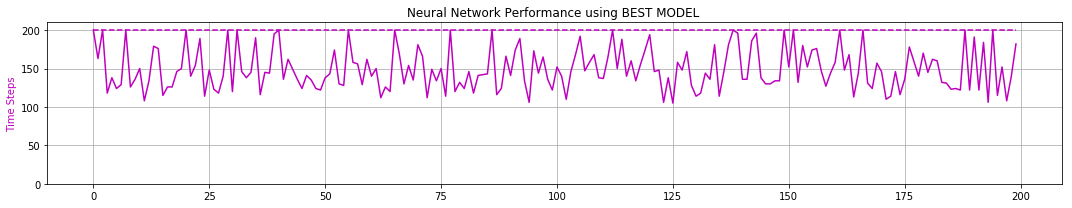

peak memory: 48976.43 MiB, increment: 43291.79 MiB
0 -max- [ 0.896  1.529  0.209  1.838  0.274]
0 -min- [-0.916 -1.904 -0.209 -2.260  0.225]

1 -max- [ 1.069  1.929  0.208  2.260  0.325]
1 -min- [-0.841 -1.827 -0.209 -2.234  0.275]

2 -max- [ 0.896  1.954  0.209  1.734  0.374]
2 -min- [-0.959 -1.876 -0.209 -1.917  0.325]

3 -max- [ 1.039  1.823  0.209  1.843  0.425]
3 -min- [-1.170 -2.024 -0.209 -2.081  0.375]

4 -max- [ 0.873  1.377  0.209  1.723  0.475]
4 -min- [-0.912 -1.692 -0.209 -2.182  0.425]

5 -max- [ 1.141  2.243  0.208  1.685  0.525]
5 -min- [-0.947 -1.849 -0.209 -1.899  0.475]

6 -max- [ 0.792  1.448  0.209  1.588  0.575]
6 -min- [-1.005 -1.876 -0.209 -2.334  0.525]

7 -max- [ 0.939  1.678  0.209  2.042  0.624]
7 -min- [-1.101 -2.050 -0.209 -1.918  0.575]

8 -max- [ 0.943  1.551  0.209  2.116  0.674]
8 -min- [-1.280 -2.204 -0.209 -2.157  0.625]

9 -max- [ 0.921  1.715  0.209  2.184  0.725]
9 -min- [-0.867 -1.875 -0.209 -2.217  0.675]

Quantization TIME:  0.39 minutes


ITER

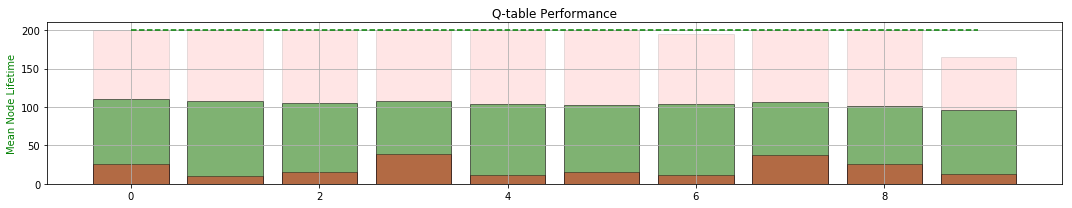

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 101.622	LOSS : 90.287	LOSS : 96.390	LOSS : 90.934	LOSS : 94.084	LOSS : 89.848	LOSS : 94.772	LOSS : 96.413	LOSS : 87.789	LOSS : 83.079	LOSS : 86.619	LOSS : 91.087	LOSS : 95.672	LOSS : 83.371	LOSS : 91.834	LOSS : 88.550	LOSS : 89.059	LOSS : 84.510	LOSS : 85.116	LOSS : 91.730	
Validating... MEAN TIME:  134.155
LOSS : 85.336	LOSS : 91.935	LOSS : 89.027	LOSS : 83.889	LOSS : 88.104	LOSS : 97.654	LOSS : 88.572	LOSS : 89.921	LOSS : 83.933	LOSS : 76.022	LOSS : 90.442	LOSS : 83.720	LOSS : 89.599	LOSS : 87.423	LOSS : 87.539	LOSS : 83.567	LOSS : 84.485	LOSS : 85.859	LOSS : 91.632	LOSS : 86.014	
Validating... MEAN TIME:  123.865
LOSS : 77.234	LOSS : 93.420	LOSS : 75.671	LOSS : 91.329	LOSS : 87.850	LOSS : 87.492	LOSS : 84.730	LOSS : 87.263	LOSS : 75.479	LOSS : 91.666	LOSS : 84.376	LOSS : 85.527	LOSS : 83.904	LOSS : 93.085	LOSS : 87.450	LOSS : 83.999	LOSS : 77.961	LOSS : 88.825	LOSS : 79.398	LOSS : 82.529	
Valid

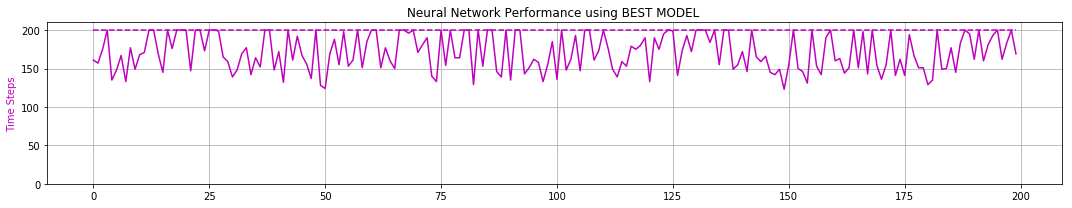

peak memory: 48959.36 MiB, increment: 43247.74 MiB
0 -max- [ 1.361  1.644  0.205  1.504  0.275]
0 -min- [-1.452 -2.249 -0.209 -1.792  0.225]

1 -max- [ 1.160  1.351  0.204  1.572  0.325]
1 -min- [-1.272 -2.156 -0.209 -1.675  0.275]

2 -max- [ 1.316  1.680  0.209  1.596  0.375]
2 -min- [-1.310 -2.058 -0.209 -1.676  0.326]

3 -max- [ 1.329  1.495  0.208  1.603  0.425]
3 -min- [-1.277 -2.068 -0.209 -2.032  0.376]

4 -max- [ 1.080  1.335  0.188  1.733  0.475]
4 -min- [-1.215 -2.070 -0.209 -2.079  0.425]

5 -max- [ 1.415  1.686  0.209  1.531  0.525]
5 -min- [-1.441 -2.179 -0.209 -1.631  0.477]

6 -max- [ 1.529  1.861  0.209  1.840  0.575]
6 -min- [-1.249 -2.128 -0.209 -1.855  0.525]

7 -max- [ 1.532  1.860  0.208  1.498  0.623]
7 -min- [-1.169 -2.009 -0.209 -1.688  0.576]

8 -max- [ 1.089  1.482  0.164  1.948  0.675]
8 -min- [-1.214 -1.877 -0.209 -2.199  0.626]

9 -max- [ 0.183  1.348  0.201  1.852  0.725]
9 -min- [-1.195 -2.060 -0.209 -2.525  0.675]

Quantization TIME:  0.39 minutes


ITER

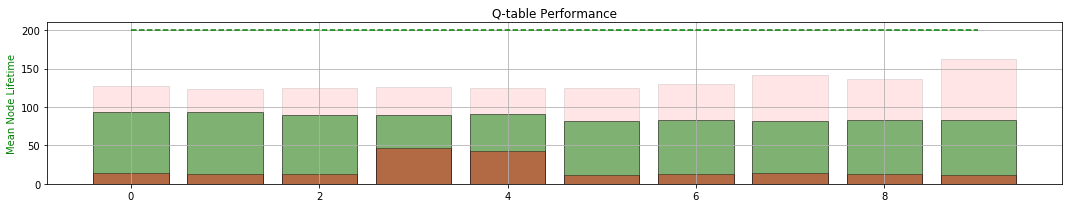

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 101.900	LOSS : 89.574	LOSS : 99.549	LOSS : 93.047	LOSS : 91.170	LOSS : 92.821	LOSS : 93.768	LOSS : 90.003	LOSS : 95.624	LOSS : 95.189	LOSS : 87.948	LOSS : 82.474	LOSS : 83.755	LOSS : 98.083	LOSS : 107.978	LOSS : 91.498	LOSS : 91.530	LOSS : 87.959	LOSS : 80.670	LOSS : 91.696	
Validating... MEAN TIME:  117.415
LOSS : 88.696	LOSS : 90.562	LOSS : 96.262	LOSS : 90.365	LOSS : 104.988	LOSS : 93.348	LOSS : 100.514	LOSS : 97.645	LOSS : 89.665	LOSS : 91.784	LOSS : 95.750	LOSS : 92.601	LOSS : 98.261	LOSS : 110.634	LOSS : 94.060	LOSS : 87.837	LOSS : 88.980	LOSS : 93.123	LOSS : 97.179	LOSS : 94.081	
Validating... MEAN TIME:  127.67
LOSS : 85.035	LOSS : 89.400	LOSS : 95.024	LOSS : 88.505	LOSS : 98.204	LOSS : 97.673	LOSS : 93.429	LOSS : 95.033	LOSS : 95.582	LOSS : 95.478	LOSS : 96.198	LOSS : 96.907	LOSS : 103.135	LOSS : 89.228	LOSS : 98.318	LOSS : 99.470	LOSS : 94.547	LOSS : 91.624	LOSS : 97.725	LOSS : 87.542	
V

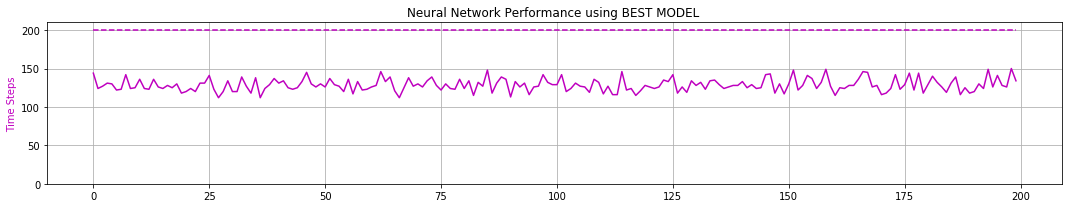

peak memory: 49354.76 MiB, increment: 43636.29 MiB
0 -max- [ 0.177  1.212  0.109  1.653  0.274]
0 -min- [-1.727 -2.245 -0.209 -1.810  0.226]

1 -max- [ 0.196  0.953  0.131  1.757  0.325]
1 -min- [-1.725 -2.256 -0.209 -1.671  0.275]

2 -max- [ 0.180  0.850  0.122  1.788  0.375]
2 -min- [-1.650 -2.254 -0.209 -1.694  0.325]

3 -max- [ 0.169  1.210  0.128  1.947  0.424]
3 -min- [-1.673 -2.182 -0.209 -1.681  0.375]

4 -max- [ 0.205  1.009  0.128  1.840  0.474]
4 -min- [-1.715 -2.208 -0.209 -1.920  0.425]

5 -max- [ 0.180  1.131  0.140  1.924  0.524]
5 -min- [-1.472 -2.091 -0.209 -1.685  0.476]

6 -max- [ 0.179  1.127  0.209  2.038  0.574]
6 -min- [-1.606 -2.387 -0.209 -2.000  0.526]

7 -max- [ 0.166  1.160  0.177  1.866  0.623]
7 -min- [-1.513 -2.207 -0.209 -1.875  0.576]

8 -max- [ 0.161  1.141  0.165  1.932  0.674]
8 -min- [-1.736 -2.338 -0.209 -1.888  0.625]

9 -max- [ 0.165  1.202  0.171  1.938  0.725]
9 -min- [-1.567 -2.181 -0.209 -2.006  0.677]

Quantization TIME:  0.39 minutes


ITER

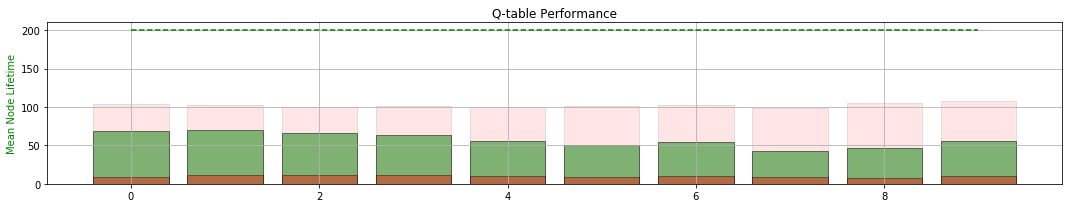

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 118.664	LOSS : 126.065	LOSS : 121.023	LOSS : 114.721	LOSS : 128.249	LOSS : 130.113	LOSS : 118.327	LOSS : 122.430	LOSS : 118.523	LOSS : 110.248	LOSS : 116.676	LOSS : 118.906	LOSS : 124.642	LOSS : 110.911	LOSS : 128.507	LOSS : 110.219	LOSS : 117.136	LOSS : 115.418	LOSS : 119.140	LOSS : 117.933	
Validating... MEAN TIME:  121.905
LOSS : 123.577	LOSS : 116.231	LOSS : 120.923	LOSS : 131.268	LOSS : 126.653	LOSS : 111.030	LOSS : 107.779	LOSS : 122.895	LOSS : 116.871	LOSS : 111.381	LOSS : 104.857	LOSS : 115.557	LOSS : 116.869	LOSS : 122.051	LOSS : 126.786	LOSS : 116.355	LOSS : 115.111	LOSS : 122.542	LOSS : 115.133	LOSS : 113.436	
Validating... MEAN TIME:  121.45
LOSS : 121.849	LOSS : 118.374	LOSS : 112.737	LOSS : 115.683	LOSS : 120.756	LOSS : 117.698	LOSS : 114.249	LOSS : 115.664	LOSS : 124.204	LOSS : 120.808	LOSS : 112.132	LOSS : 120.099	LOSS : 111.999	LOSS : 106.148	LOSS : 121.159	LOSS : 127.019	LOSS : 1

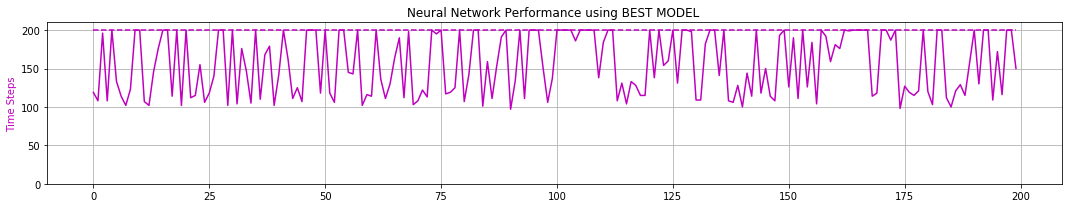

peak memory: 49304.48 MiB, increment: 43562.49 MiB
0 -max- [ 0.213  1.396  0.049  1.012  0.274]
0 -min- [-1.886 -2.573 -0.209 -1.991  0.227]

1 -max- [ 0.190  1.401  0.050  1.236  0.325]
1 -min- [-1.954 -2.573 -0.209 -1.996  0.276]

2 -max- [ 0.195  1.408  0.050  1.167  0.375]
2 -min- [-2.143 -2.569 -0.209 -1.990  0.325]

3 -max- [ 0.210  1.390  0.048  1.252  0.425]
3 -min- [-2.176 -2.586 -0.209 -2.039  0.375]

4 -max- [ 0.214  1.394  0.050  1.180  0.475]
4 -min- [-2.077 -2.573 -0.209 -1.986  0.426]

5 -max- [ 0.198  1.405  0.049  1.218  0.525]
5 -min- [-2.048 -2.407 -0.209 -1.994  0.476]

6 -max- [ 0.196  1.216  0.049  1.211  0.575]
6 -min- [-1.856 -2.393 -0.209 -1.793  0.526]

7 -max- [ 0.208  1.402  0.051  1.552  0.625]
7 -min- [-1.769 -2.386 -0.209 -1.996  0.575]

8 -max- [ 0.222  1.399  0.049  1.228  0.674]
8 -min- [-1.890 -2.383 -0.209 -1.998  0.626]

9 -max- [ 0.219  1.407  0.050  1.310  0.725]
9 -min- [-1.972 -2.414 -0.209 -2.040  0.677]

Quantization TIME:  0.4 minutes


ITERA

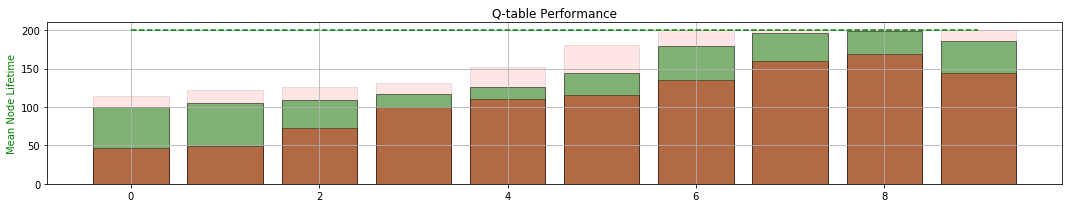

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 151.297	LOSS : 161.233	LOSS : 127.162	LOSS : 115.346	LOSS : 104.912	LOSS : 115.148	LOSS : 109.233	LOSS : 113.547	LOSS : 108.209	LOSS : 103.127	LOSS : 105.882	LOSS : 95.795	LOSS : 107.924	LOSS : 117.461	LOSS : 103.570	LOSS : 97.951	LOSS : 103.179	LOSS : 101.073	LOSS : 99.445	LOSS : 100.287	
Validating... MEAN TIME:  144.85
LOSS : 99.284	LOSS : 95.891	LOSS : 102.420	LOSS : 103.795	LOSS : 99.418	LOSS : 107.926	LOSS : 98.881	LOSS : 108.177	LOSS : 100.763	LOSS : 110.261	LOSS : 109.540	LOSS : 103.589	LOSS : 97.800	LOSS : 98.359	LOSS : 106.034	LOSS : 102.123	LOSS : 102.341	LOSS : 108.931	LOSS : 96.093	LOSS : 109.359	
Validating... MEAN TIME:  197.26
LOSS : 99.503	LOSS : 116.562	LOSS : 101.204	LOSS : 107.701	LOSS : 100.293	LOSS : 95.718	LOSS : 102.387	LOSS : 107.750	LOSS : 103.541	LOSS : 92.063	LOSS : 101.579	LOSS : 109.977	LOSS : 107.135	LOSS : 107.122	LOSS : 100.582	LOSS : 110.071	LOSS : 114.732	LOSS : 

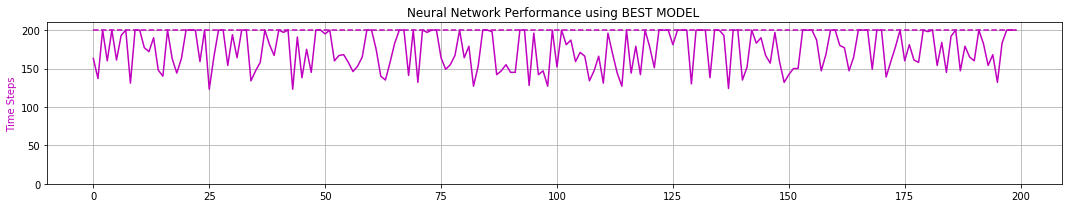

peak memory: 49243.38 MiB, increment: 43469.70 MiB
0 -max- [ 0.148  0.632  0.050  0.705  0.275]
0 -min- [-2.399 -3.234 -0.209 -0.921  0.226]

1 -max- [ 0.148  0.624  0.050  0.644  0.324]
1 -min- [-2.399 -3.052 -0.209 -0.911  0.277]

2 -max- [ 0.167  0.579  0.048  0.676  0.375]
2 -min- [-2.400 -3.120 -0.209 -0.897  0.326]

3 -max- [ 0.151  0.574  0.050  0.670  0.424]
3 -min- [-2.400 -2.949 -0.205 -0.890  0.375]

4 -max- [ 0.163  0.612  0.049  0.818  0.475]
4 -min- [-2.399 -3.077 -0.206 -0.983  0.425]

5 -max- [ 0.148  0.579  0.049  0.721  0.524]
5 -min- [-2.400 -2.742 -0.209 -1.058  0.475]

6 -max- [ 0.392  0.745  0.074  0.810  0.574]
6 -min- [-2.400 -2.768 -0.209 -1.029  0.525]

7 -max- [ 1.777  1.782  0.190  0.935  0.625]
7 -min- [-2.397 -2.758 -0.208 -1.031  0.575]

8 -max- [ 2.385  3.005  0.208  0.860  0.675]
8 -min- [-2.390 -2.790 -0.209 -1.133  0.625]

9 -max- [ 2.398  3.372  0.209  1.110  0.724]
9 -min- [-1.404 -1.824 -0.169 -1.780  0.676]

Quantization TIME:  0.39 minutes


ITER

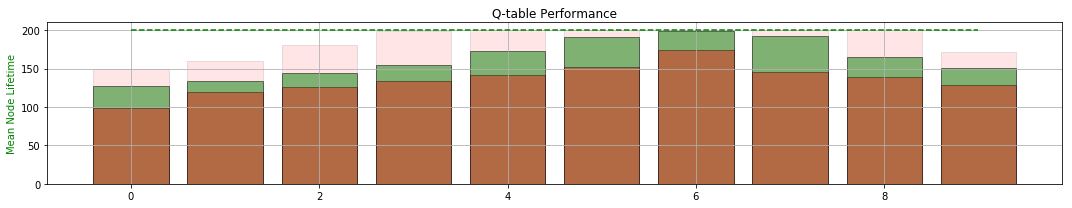

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 80.621	LOSS : 87.185	LOSS : 88.597	LOSS : 86.207	LOSS : 77.012	LOSS : 72.813	LOSS : 79.867	LOSS : 79.684	LOSS : 66.476	LOSS : 65.751	LOSS : 74.682	LOSS : 72.534	LOSS : 70.280	LOSS : 66.636	LOSS : 72.260	LOSS : 76.693	LOSS : 63.415	LOSS : 72.719	LOSS : 56.948	LOSS : 74.352	
Validating... MEAN TIME:  200.0
LOSS : 67.228	LOSS : 70.198	LOSS : 65.614	LOSS : 69.410	LOSS : 67.745	LOSS : 73.343	LOSS : 75.500	LOSS : 56.766	LOSS : 67.533	LOSS : 71.326	LOSS : 63.435	LOSS : 58.330	LOSS : 53.639	LOSS : 64.432	LOSS : 65.520	LOSS : 74.533	LOSS : 64.487	LOSS : 61.134	LOSS : 60.293	LOSS : 54.862	
Validating... MEAN TIME:  158.32
LOSS : 56.188	LOSS : 65.315	LOSS : 65.411	LOSS : 76.667	LOSS : 62.113	LOSS : 54.941	LOSS : 71.409	LOSS : 61.695	LOSS : 70.604	LOSS : 72.948	LOSS : 65.450	LOSS : 58.334	LOSS : 64.363	LOSS : 59.797	LOSS : 62.409	LOSS : 61.684	LOSS : 60.135	LOSS : 64.935	LOSS : 62.829	LOSS : 55.577	
Validatin

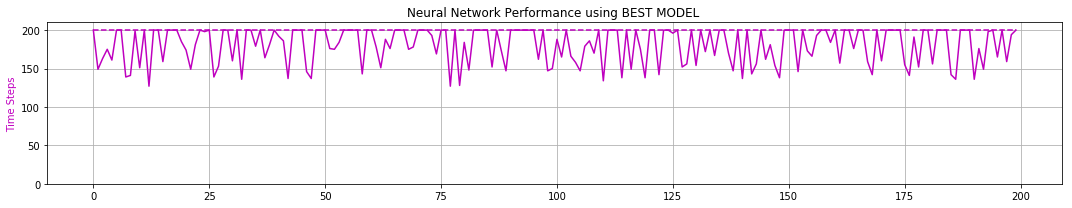

peak memory: 49465.21 MiB, increment: 43712.32 MiB
0 -max- [ 0.107  0.822  0.050  0.854  0.275]
0 -min- [-2.400 -2.913 -0.208 -1.128  0.225]

1 -max- [ 0.125  0.730  0.048  0.963  0.325]
1 -min- [-2.399 -2.799 -0.208 -1.138  0.275]

2 -max- [ 0.132  0.613  0.050  0.954  0.375]
2 -min- [-2.399 -2.584 -0.185 -0.890  0.325]

3 -max- [ 0.114  0.589  0.049  0.875  0.425]
3 -min- [-2.399 -2.590 -0.194 -1.041  0.376]

4 -max- [ 0.211  0.573  0.049  0.944  0.475]
4 -min- [-2.399 -2.413 -0.198 -1.022  0.425]

5 -max- [ 2.390  2.578  0.197  0.887  0.525]
5 -min- [-2.400 -2.400 -0.206 -0.871  0.475]

6 -max- [ 2.391  2.430  0.187  0.961  0.575]
6 -min- [-2.397 -2.047 -0.186 -0.863  0.526]

7 -max- [ 2.399  2.435  0.184  0.797  0.624]
7 -min- [-1.844 -1.346 -0.109 -0.810  0.575]

8 -max- [ 2.400  2.580  0.198  0.886  0.675]
8 -min- [-0.164 -0.577 -0.050 -0.672  0.625]

9 -max- [ 2.400  2.593  0.195  0.884  0.725]
9 -min- [-0.112 -0.619 -0.049 -0.760  0.675]

Quantization TIME:  0.39 minutes


ITER

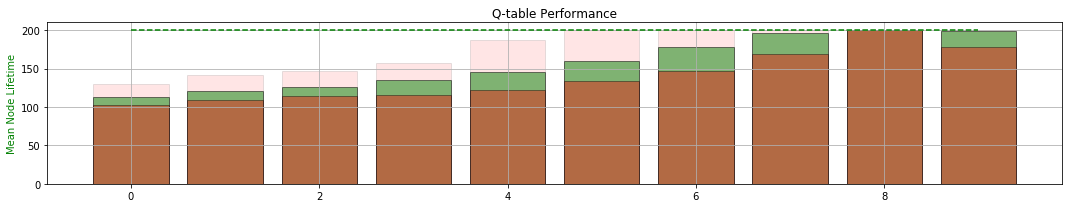

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 50.238	LOSS : 61.009	LOSS : 50.651	LOSS : 55.414	LOSS : 59.046	LOSS : 58.977	LOSS : 58.294	LOSS : 55.553	LOSS : 57.840	LOSS : 59.028	LOSS : 53.039	LOSS : 62.228	LOSS : 50.986	LOSS : 59.006	LOSS : 57.958	LOSS : 64.549	LOSS : 61.916	LOSS : 50.856	LOSS : 54.339	LOSS : 58.224	
Validating... MEAN TIME:  199.35
LOSS : 54.792	LOSS : 51.990	LOSS : 53.598	LOSS : 49.244	LOSS : 52.440	LOSS : 46.103	LOSS : 62.115	LOSS : 58.173	LOSS : 60.569	LOSS : 53.939	LOSS : 54.444	LOSS : 58.293	LOSS : 52.700	LOSS : 62.558	LOSS : 53.922	LOSS : 59.308	LOSS : 56.811	LOSS : 60.404	LOSS : 56.232	LOSS : 50.950	
Validating... MEAN TIME:  199.625
LOSS : 56.268	LOSS : 62.823	LOSS : 59.775	LOSS : 58.752	LOSS : 58.583	LOSS : 55.698	LOSS : 68.455	LOSS : 57.262	LOSS : 58.262	LOSS : 57.737	LOSS : 56.689	LOSS : 62.899	LOSS : 49.982	LOSS : 49.329	LOSS : 54.523	LOSS : 60.095	LOSS : 54.757	LOSS : 57.994	LOSS : 64.245	LOSS : 48.250	
Validat

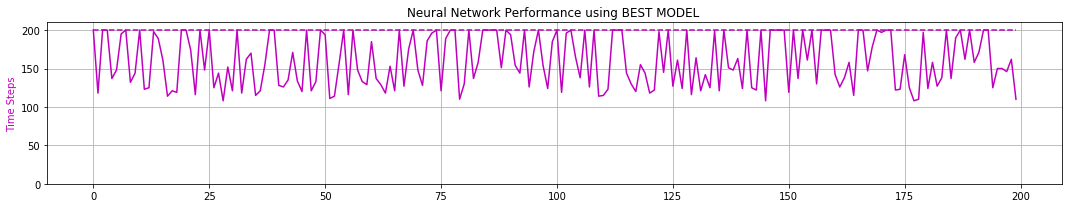

peak memory: 49312.56 MiB, increment: 43512.29 MiB
0 -max- [ 0.154  0.605  0.048  0.863  0.274]
0 -min- [-2.399 -2.801 -0.181 -0.880  0.225]

1 -max- [ 0.148  0.603  0.050  0.682  0.325]
1 -min- [-2.400 -2.746 -0.189 -0.866  0.275]

2 -max- [ 0.140  0.589  0.049  0.766  0.374]
2 -min- [-2.400 -2.595 -0.177 -0.869  0.327]

3 -max- [ 0.134  0.554  0.049  0.679  0.424]
3 -min- [-2.400 -2.418 -0.163 -0.798  0.375]

4 -max- [ 0.134  0.621  0.050  0.826  0.475]
4 -min- [-2.400 -2.428 -0.151 -0.969  0.425]

5 -max- [ 0.177  0.612  0.049  0.728  0.525]
5 -min- [-2.399 -2.254 -0.164 -1.095  0.476]

6 -max- [ 0.201  0.621  0.050  0.711  0.575]
6 -min- [-2.400 -2.216 -0.157 -0.900  0.525]

7 -max- [ 0.660  0.607  0.049  0.725  0.625]
7 -min- [-2.400 -2.035 -0.159 -0.770  0.575]

8 -max- [ 1.431  1.273  0.109  0.790  0.674]
8 -min- [-2.182 -1.470 -0.132 -0.766  0.626]

9 -max- [ 2.399  2.412  0.171  0.901  0.725]
9 -min- [-0.715 -0.579 -0.053 -0.936  0.675]

Quantization TIME:  0.4 minutes


ITERA

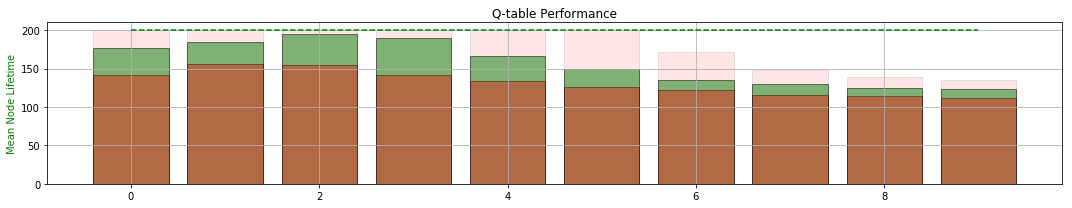

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 69.881	LOSS : 56.960	LOSS : 64.482	LOSS : 50.923	LOSS : 74.914	LOSS : 68.413	LOSS : 63.636	LOSS : 69.670	LOSS : 62.208	LOSS : 56.181	LOSS : 56.235	LOSS : 60.932	LOSS : 62.342	LOSS : 59.733	LOSS : 58.047	LOSS : 58.870	LOSS : 56.837	LOSS : 62.901	LOSS : 63.056	LOSS : 56.591	
Validating... MEAN TIME:  117.205
LOSS : 63.899	LOSS : 66.659	LOSS : 57.620	LOSS : 68.659	LOSS : 66.701	LOSS : 55.964	LOSS : 65.920	LOSS : 69.968	LOSS : 71.804	LOSS : 56.175	LOSS : 59.166	LOSS : 59.236	LOSS : 51.553	LOSS : 58.081	LOSS : 51.979	LOSS : 59.291	LOSS : 53.347	LOSS : 55.598	LOSS : 57.868	LOSS : 57.202	
Validating... MEAN TIME:  193.94
LOSS : 66.428	LOSS : 64.874	LOSS : 60.753	LOSS : 56.818	LOSS : 64.204	LOSS : 60.556	LOSS : 47.366	LOSS : 71.392	LOSS : 53.211	LOSS : 64.086	LOSS : 63.667	LOSS : 59.595	LOSS : 54.552	LOSS : 64.760	LOSS : 66.542	LOSS : 64.050	LOSS : 57.959	LOSS : 61.503	LOSS : 50.773	LOSS : 54.600	
Validat

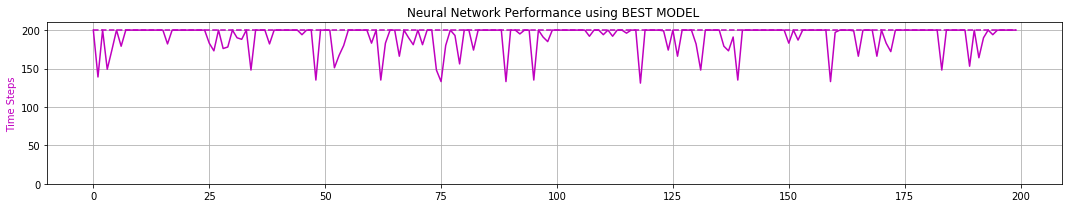

peak memory: 49513.01 MiB, increment: 43745.29 MiB
0 -max- [ 0.616  0.633  0.050  0.701  0.275]
0 -min- [-2.400 -2.769 -0.191 -0.886  0.225]

1 -max- [ 2.389  2.415  0.160  0.844  0.324]
1 -min- [-2.400 -2.620 -0.188 -0.943  0.276]

2 -max- [ 2.396  2.543  0.175  0.778  0.375]
2 -min- [-2.400 -2.574 -0.195 -0.884  0.326]

3 -max- [ 2.398  2.938  0.202  1.062  0.425]
3 -min- [-2.394 -2.232 -0.145 -1.004  0.376]

4 -max- [ 2.399  2.739  0.174  0.927  0.475]
4 -min- [-0.239 -0.434 -0.049 -0.924  0.425]

5 -max- [ 2.400  2.610  0.162  0.820  0.525]
5 -min- [-0.163 -0.578 -0.049 -0.873  0.478]

6 -max- [ 2.399  2.615  0.173  1.086  0.575]
6 -min- [-0.176 -0.579 -0.050 -0.843  0.525]

7 -max- [ 2.399  2.708  0.196  1.091  0.625]
7 -min- [-0.126 -0.579 -0.049 -0.874  0.576]

8 -max- [ 2.400  2.623  0.202  1.078  0.674]
8 -min- [-0.128 -0.633 -0.050 -0.910  0.626]

9 -max- [ 2.399  2.742  0.176  0.910  0.725]
9 -min- [-0.144 -0.631 -0.046 -0.918  0.675]

Quantization TIME:  0.39 minutes


ITER

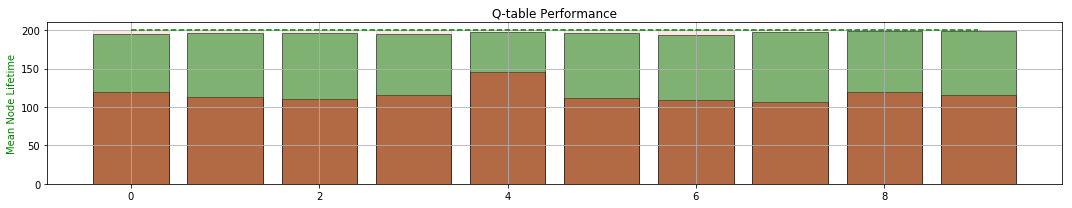

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)

            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1717.0
Total Serial Timesteps   :  1189328.0
Speed-up                 :  692.68


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9086 SUCCESS 107   9    1717    1189328     692.68
